
# Module 2 Assignment
## Implementation of the consensus algorithm
### Prasanna Bartakke EE19B106



Enter the name of the file which has the input hashgraph

In [ ]:
filename = "test3.txt"

Go to Runtime and select Run All

In [ ]:
from collections import defaultdict
from enum import Enum
from functools import lru_cache
import statistics
import graphviz

# set debug = 1 to see the intermediate outputs
DEBUG = 0

class famous(Enum):
  UNDECIDED = 0
  NO = -1
  YES = 1

def log(s):
  if DEBUG:
    print(s)

C = 10

In [ ]:
class Event:
  def __init__(self, node_id, event_id, parent_event_id, self_parent_event_id, timestamp):
    self.node_id = node_id
    self.event_id = event_id
    self.parent_event_id = parent_event_id
    self.self_parent_event_id = self_parent_event_id
    self.timestamp = timestamp
    self.round = None
    self.witness = False
    self.famous = None
    self.vote = None
    self.round_received = None
    self.consensus_timestamp = None

In [ ]:
def print_events():
  """
    prints all properties for all events
  """
  for event in events:
    log(f"Id: {event.event_id} Node Id: {event.node_id} Parent: {event.parent_event_id} Self Parent: {event.self_parent_event_id} Round Created: {event.round} Witness: {event.witness} Fame: {event.famous} Round Received: {event.round_received} Consensus timestamp: {event.consensus_timestamp}")

def supermajority(N):
    return (2/3) * N

def get_max_parents_round(event: Event):
  """
    returns the max round of the parents of the event, if no parents of event, returns 1
  """
  if not event.parent_event_id:
    parent_event_round = 1
  else:  
    parent_event_round = event_id_to_event_obj_map[event.parent_event_id].round

  if not event.self_parent_event_id:
    self_parent_event_round = 1
  else:
    self_parent_event_round = event_id_to_event_obj_map[event.self_parent_event_id].round
    
  return max(parent_event_round, self_parent_event_round)



In [ ]:
@lru_cache(None)
def see(y: Event, x: Event):
  """
  returns distinct members in the path from event y to event x
  if y cannot see x, returns empty set
  """
  if not y:
    return set()

  if y.event_id == x.event_id:
    return set([x.node_id])

  y_parent_event = event_id_to_event_obj_map.get(y.parent_event_id)
  y_self_parent_event = event_id_to_event_obj_map.get(y.self_parent_event_id)

  can_see = see(y_parent_event, x) | see(y_self_parent_event, x)

  if can_see:
    can_see |= set([y.node_id])

  if can_see:
    log(f"Event {y.event_id} can see event {x.event_id}")
  else:
    log(f"Event {y.event_id} cannot see event {x.event_id}")

  return can_see

@lru_cache(None)
def strongly_see(w: Event, x: Event, r):
  """
  returns true if event w can strongly see event x
  """
  if not see(w, x):
    return False

  # if w can see supermajority of events which can see x, then w can strongly see x
  w_can_see = set()
  for event in events:
    if see(w, event) and see(event, x):
      w_can_see |= see(w, event)

  return len(w_can_see) > supermajority(N)

@lru_cache(None)
def ancestor(x: Event, y: Event):
  """
    returns True if x is ancestor of y, i.e. y can see x
  """
  return len(see(y, x)) > 0

@lru_cache(None)
def self_ancestor(x: Event, y: Event):
  """
    returns True if x is self ancestor of y
  """

  if not y:
    return False

  if y.event_id == x.event_id:
    return True

  
  y_self_parent_event = event_id_to_event_obj_map.get(y.self_parent_event_id)

  can_self_see = self_ancestor(x, y_self_parent_event)

 
  if can_self_see:
    log(f"Event {y.event_id} can self see event {x.event_id}")
  else:
    log(f"Event {y.event_id} cannot self see event {x.event_id}")

  return can_self_see

The divide_rounds procedure. As soon as an event is known, it is assigned a round number event.round, and the boolean value event.witness is calculated, indicating whether it is a "witness", the first event that a member created in that round.

In [ ]:
def divide_rounds():
  for event in events:
    r = get_max_parents_round(event)

    # increment event's round if it can strongly see > 2/3rd round r witnesses
    count_strongly_seen_round_r_witness = 0

    for witness_event_id in witness[r]:
      rth_round_witness_event = event_id_to_event_obj_map[witness_event_id]
      if r and strongly_see(event, rth_round_witness_event, r):
        count_strongly_seen_round_r_witness += 1

    if count_strongly_seen_round_r_witness > supermajority(N):
      event.round = r + 1
    else:
      event.round = r

    # check if witness
    self_parent_event = event_id_to_event_obj_map.get(event.self_parent_event_id)

    if (not self_parent_event) or (event.round > self_parent_event.round):
      event.witness = True
      witness[event.round].append(event.event_id)
    

The decide_fame procedure. For each witness event (i.e., an event x where x.witness is true), decide whether it is famous (i.e., assign a boolean to x.famous). This decision is done by a Byzantine agreement protocol based on virtual voting. Each member runs it locally, on their own copy of the hashgraph, with no additional communication. It treats the events in the hashgraph as if they were sending votes to each other, though the calculation
is purely local to a member’s computer. The member assigns votes to the witnesses of each round, for several rounds, until more than 2/3 of the population agrees. To find the fame of x, re-run this repeatedly on the growing hashgraph until x.famous receives a value.

In [ ]:
def get_middle_bit(x):
  bin_x = bin(x)[2:] 

  # if even length, return xor of middle 2 bits
  if len(bin_x) % 2 == 0:
    return int(bin_x[len(bin_x) // 2]) ^ int(bin_x[(len(bin_x)-1) // 2])
  else:
    return int(bin_x[len(bin_x) // 2])

def decide_fame():
  # for each event x in order from earlier rounds to later
  for x in events:
    x.famous = famous.UNDECIDED
    # for each event y in order from earlier rounds to later
    for y in events:
      if x.witness and y.witness and y.round > x.round:

        d = y.round - x.round
        
        # first round of election
        if d == 1:
          if see(y, x):
            y.vote = famous.YES
          else:
            y.vote = famous.NO
        else:

          #set of witnesses in round y.round - 1 that y can strongly see
          s = set()
          for witness_event_id in witness[y.round - 1]:
            witness_event = event_id_to_event_obj_map[witness_event_id]
            if strongly_see(y, witness_event, y.round-1):
              s.add(witness_event)

          # v - majority vote in s(is famous.YES for a tie)
          # t - number of events in s with a vote of v
          vote_count = {famous.YES: 0, famous.NO: 0}
          for event in s:
            vote_count[event.vote] += 1
          if vote_count[famous.YES] >= vote_count[famous.NO]:
            v = famous.YES
            t = vote_count[famous.YES]
          else:
            v = famous.NO
            t = vote_count[famous.NO]

          # normal round
          if d % C > 0:
            # if supermajority then decide
            if t > supermajority(N):
              x.famous = v
              y.vote = v
              break
            # else, just vote
            else:
              y.vote = v
          # coin round
          else:
            # if supermajority then vote
            if t > supermajority(N):
              y.vote = v
            # else flip a coin
            else:
              # middle bit of event id of y
              middle_bit = get_middle_bit(y.event_id)
              if middle_bit:
                y.vote = famous.NO
              else:
                y.vote = famous.YES

The find_order procedure. Once all the witnesses in round r have their fame decided, find the set of famous witnesses in that round, then remove from that set any famous witness that has the same creator as any other in that set. The remaining famous witnesses are the unique famous witnesses. They act as the judges to assign earlier events a round received and consensus timestamp. An event is said to be "received" in the first round where all the unique famous witnesses have received it, if all earlier rounds have the fame of all witnesses decided. Its timestamp is the median of the timestamps of those events where each of those members first received it. Once these have been calculated, the events are sorted by round received. Any ties are subsorted by consensus timestamp. Any remaining ties are subsorted by whitened signature. The whitened signature is the signature XORed with the
signatures of all unique famous witnesses in the received round.

In [ ]:
def find_order():
  # find the unique famous witnesses(having unique creators) in each round
  unq_witness = defaultdict(list)

  for r in witness:
    seen_ = set()
    for w_id in witness[r]:
      w = event_id_to_event_obj_map[w_id]
      if w.famous != famous.YES:
        continue
      if w.node_id not in seen_:
        seen_.add(w.node_id)
        unq_witness[r].append(w_id)

    
  for x in events:
    r = None
    for r_ in sorted(witness):
      no_undecided_famous = True
      x_ancestor_all = True

      # if there is a round such that there is no event y in or before round r that
      # has y.witness = True and y.famous = famous.UNDECIDED
      for y_id in witness[r_]:
        y = event_id_to_event_obj_map[y_id]
        if y.famous == famous.UNDECIDED:
          no_undecided_famous = False
      
      # x is an ancestor of every round r unique famous witness
      for y_id in unq_witness[r_]:
        y = event_id_to_event_obj_map[y_id]
        if not ancestor(x, y):
          x_ancestor_all = False

      if no_undecided_famous and x_ancestor_all:
        # if both conditions are True and as r_ is the first round where this happens
        r = r_
        break
    else:
      log(f"Round received not found for Event id: {x.event_id}")
      continue

    log(f"Event id: {x.event_id} Round received: {r}")
    x.round_received = r

    # set of each event z such that z is a self-ancestor of a round r unique famous
    # witness, and x is an ancestor of z but not of the self-parent of z
    s = set()
    for z in events:
      for w_id in unq_witness[r]:
        w = event_id_to_event_obj_map[w_id]
        if self_ancestor(z, w) and ancestor(x, z) and not ancestor(x, event_id_to_event_obj_map.get(z.self_parent_event_id)):
          s.add(z.event_id)
    
    # consensus timestamp is the median of timestamps of all the events in s
    ts = [event_id_to_event_obj_map[z].timestamp for z in s]
    if ts:
      x.consensus_timestamp = statistics.median(ts)

  # consensus order sorted by round_received, consensus_timestamp and event_id
  order = []
  for event in events:
    if event.round_received:
      order.append([event.round_received, event.consensus_timestamp, event.event_id])
  order.sort()
  return order

  

Read events from the file and make the hashgraph.

In [ ]:
event_id_to_event_obj_map = {}
events = []
witness = defaultdict(list)


hfile = open(filename)
lines = hfile.readlines()
N = int(lines[0].strip())
i = 1
while lines[i].strip() != "Done":
  line = lines[i].strip().split()
  node_id = int(line[0])
  event_id = int(line[1])

  if line[2] == "NULL":
    parent_event_id = None
  else:
    parent_event_id = int(line[2])

  if line[3] == "NULL":
    self_parent_event_id = None
  else:
    self_parent_event_id = int(line[3])

  timestamp = int(line[4])

  event = Event(node_id, event_id, parent_event_id, self_parent_event_id, timestamp)

  event_id_to_event_obj_map[event_id] = event

  events.append(event)

  i += 1

Plot the input hashgraph

<IPython.core.display.Javascript object>

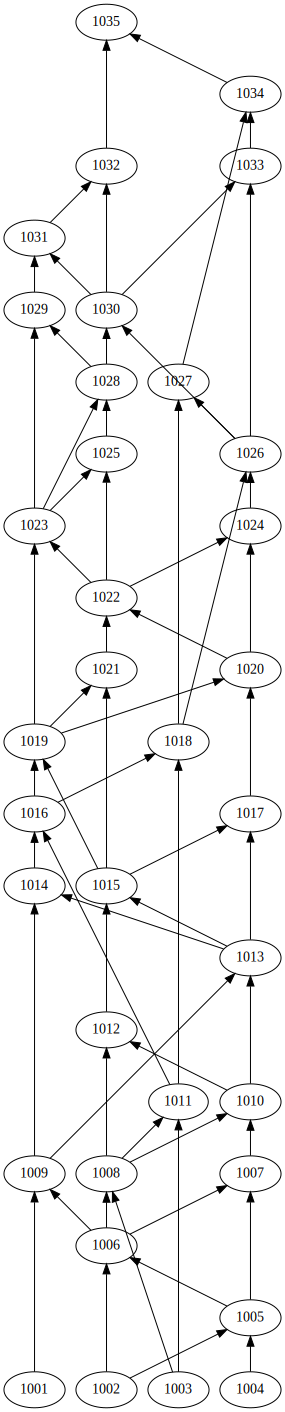

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

g = graphviz.Digraph('G', filename = "input.png", engine="neato")

for event in  events:
  g.node(str(event.event_id), pos=f"{event.node_id},{event.timestamp}!")


for event in events:
  op = event_id_to_event_obj_map.get(event.parent_event_id)
  sp = event_id_to_event_obj_map.get(event.self_parent_event_id)
  if op:
    g.edge(f"{op.event_id}", f"{event.event_id}")
  if sp:
    g.edge(f"{sp.event_id}", f"{event.event_id}")
g

The above image shows the input hashgraph. Each event has the event id.

In [ ]:
divide_rounds()

<IPython.core.display.Javascript object>

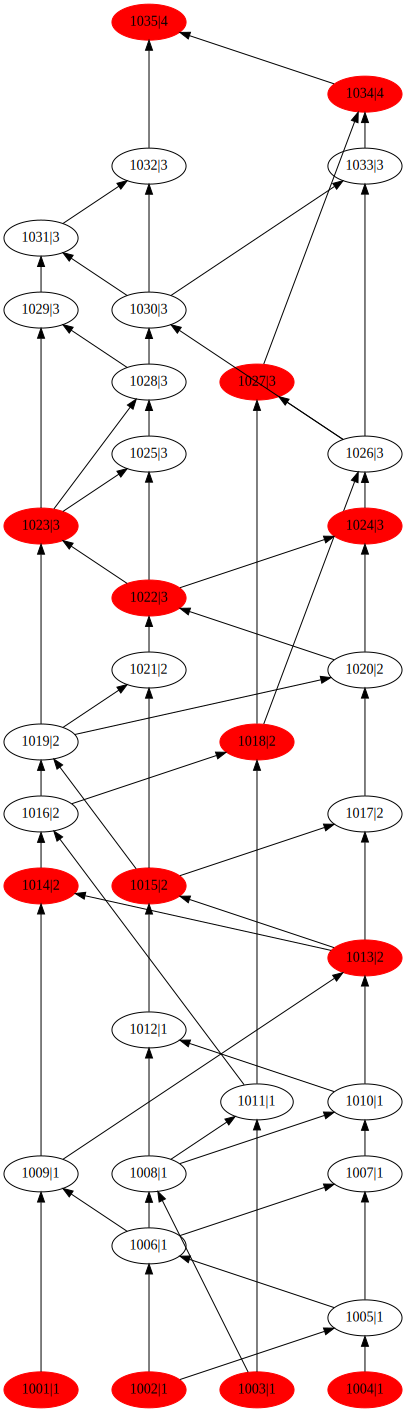

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

g = graphviz.Digraph('G', filename = "divide_rounds_output.png", engine="neato")

for event in  events:
  if event.witness:
    g.node(str(event.event_id), label=f"{event.event_id}|{event.round}", pos=f"{event.node_id*1.5},{event.timestamp}!", color="red", style="filled")
  else:
    g.node(str(event.event_id), label=f"{event.event_id}|{event.round}", pos=f"{event.node_id*1.5},{event.timestamp}!")


for event in events:
  op = event_id_to_event_obj_map.get(event.parent_event_id)
  sp = event_id_to_event_obj_map.get(event.self_parent_event_id)
  if op:
    g.edge(f"{op.event_id}", f"{event.event_id}")
  if sp:
    g.edge(f"{sp.event_id}", f"{event.event_id}")
    
    
g

The above image shows the state of the hashgraph after the divide rounds procedure. Each event has been assigned the round created value. Each event has the following format: {event_id}|{round_created}. <br>
The events in red are the witnesses.

In [ ]:
decide_fame()

<IPython.core.display.Javascript object>

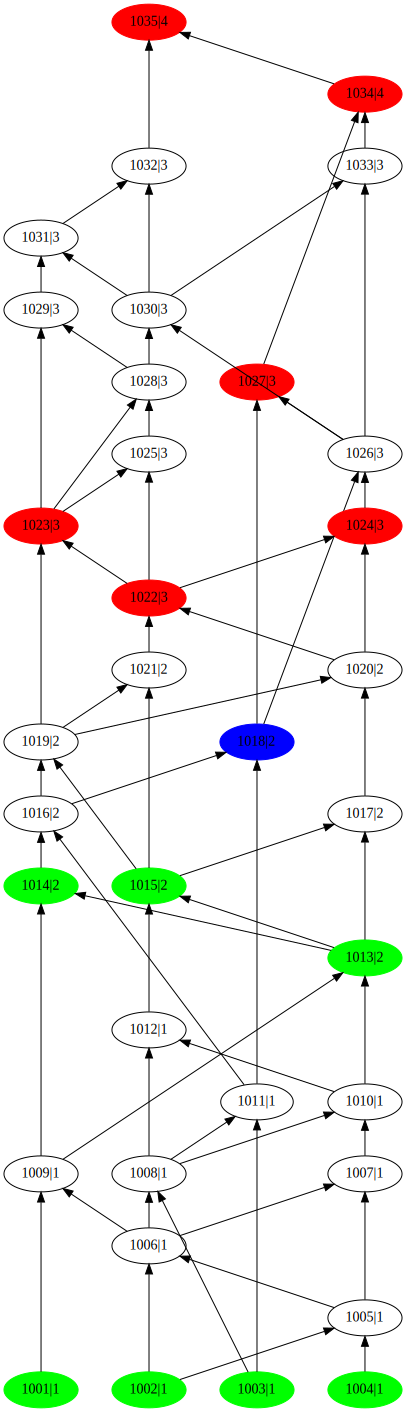

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

g = graphviz.Digraph('G', filename = "decide_fame_output", engine="neato")

for event in  events:
  if event.witness:
    if event.famous == famous.YES:
      g.node(str(event.event_id), label=f"{event.event_id}|{event.round}", pos=f"{event.node_id*1.5},{event.timestamp}!", color="green", style="filled")
    elif event.famous == famous.NO:
      g.node(str(event.event_id), label=f"{event.event_id}|{event.round}", pos=f"{event.node_id*1.5},{event.timestamp}!", color="blue", style="filled")
    elif event.famous == famous.UNDECIDED:
      g.node(str(event.event_id), label=f"{event.event_id}|{event.round}", pos=f"{event.node_id*1.5},{event.timestamp}!", color="red", style="filled")
  else:
    g.node(str(event.event_id), label=f"{event.event_id}|{event.round}", pos=f"{event.node_id*1.5},{event.timestamp}!")


for event in events:
  op = event_id_to_event_obj_map.get(event.parent_event_id)
  sp = event_id_to_event_obj_map.get(event.self_parent_event_id)
  if op:
    g.edge(f"{op.event_id}", f"{event.event_id}")
  if sp:
    g.edge(f"{sp.event_id}", f"{event.event_id}")
       
g

The above image shows the state of the hashgraph after the divide rounds procedure. Each witness has been assigned the value of fame. <br>
The witnesses in red have undecided fame.<br>
The witnesses in green are famous.<br>
The witnesses in blue are not famous.


In [ ]:
order = find_order()

<IPython.core.display.Javascript object>

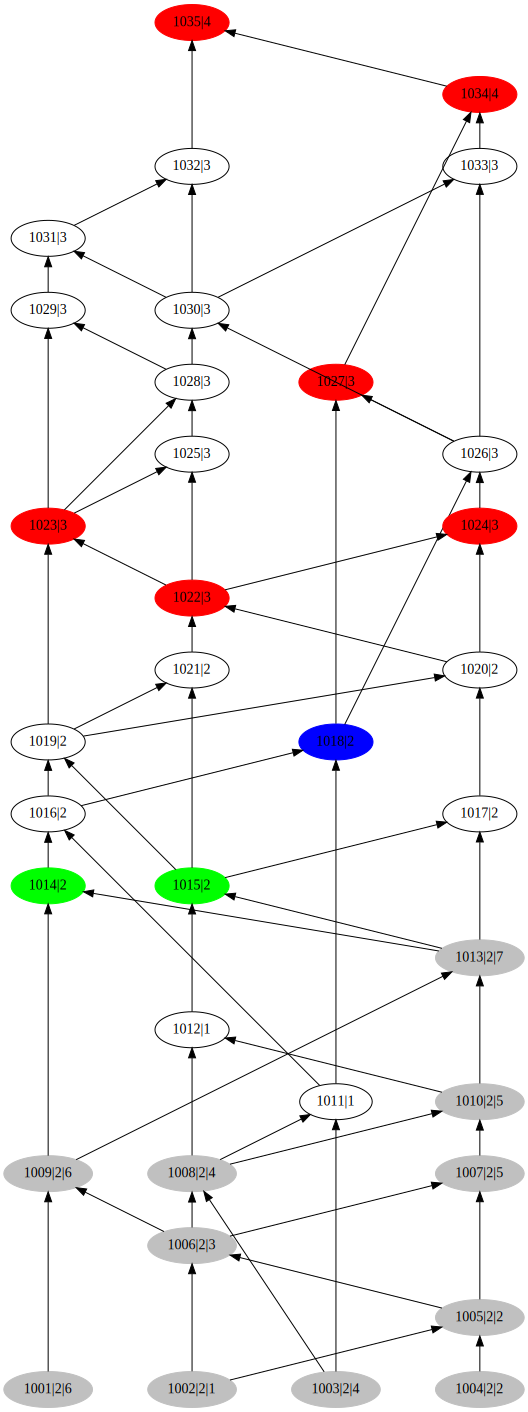

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

g = graphviz.Digraph('G', filename = "find_order_output", engine="neato")

for event in events:
  if event.round_received:
    g.node(str(event.event_id), label=f"{event.event_id}|{event.round_received}|{event.consensus_timestamp}", pos=f"{event.node_id*2},{event.timestamp}!", color="grey", style="filled")
  elif event.witness:
    if event.famous == famous.YES:
      g.node(str(event.event_id), label=f"{event.event_id}|{event.round}", pos=f"{event.node_id*2},{event.timestamp}!", color="green", style="filled")
    elif event.famous == famous.NO:
      g.node(str(event.event_id), label=f"{event.event_id}|{event.round}", pos=f"{event.node_id*2},{event.timestamp}!", color="blue", style="filled")
    elif event.famous == famous.UNDECIDED:
      g.node(str(event.event_id), label=f"{event.event_id}|{event.round}", pos=f"{event.node_id*2},{event.timestamp}!", color="red", style="filled")
  else:
    g.node(str(event.event_id), label=f"{event.event_id}|{event.round}", pos=f"{event.node_id*2},{event.timestamp}!")


for event in events:
  op = event_id_to_event_obj_map.get(event.parent_event_id)
  sp = event_id_to_event_obj_map.get(event.self_parent_event_id)
  if op:
    g.edge(f"{op.event_id}", f"{event.event_id}")
  if sp:
    g.edge(f"{sp.event_id}", f"{event.event_id}")
       
g

After the find order procecure some events have been ordered. <br>
The events in grey are present in the consensus order. Each event has the following format:<br> 
{event_id}|{round_received}|{consensus_timestamp}. <br>

In [ ]:
print("Consensus order:")
for event in order:
  print(f"Event Id: {event[2]} Round received: {event[0]} Consensus timestamp: {event[1]}")

Consensus order:
Event Id: 1002 Round received: 2 Consensus timestamp: 1
Event Id: 1004 Round received: 2 Consensus timestamp: 2
Event Id: 1005 Round received: 2 Consensus timestamp: 2
Event Id: 1006 Round received: 2 Consensus timestamp: 3
Event Id: 1003 Round received: 2 Consensus timestamp: 4
Event Id: 1008 Round received: 2 Consensus timestamp: 4
Event Id: 1007 Round received: 2 Consensus timestamp: 5
Event Id: 1010 Round received: 2 Consensus timestamp: 5
Event Id: 1001 Round received: 2 Consensus timestamp: 6
Event Id: 1009 Round received: 2 Consensus timestamp: 6
Event Id: 1013 Round received: 2 Consensus timestamp: 7
